##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [69]:
#%pip install pandas 
#%pip install matplotlib
#%pip install numpy
#%pip install seaborn
#%pip install -U scikit-learn
#%pip install pyarrow
#%pip install fastparquet
#%pip install -U imbalanced-learn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 


2298.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
2304.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
2311.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
2317.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

filepath = "./data/catB_train.parquet" 

# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file


### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [2]:
df = pd.read_parquet(filepath)
df.head(5)


,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


Dropping columns with only 1 value

In [3]:
df['f_purchase_lh'] = df['f_purchase_lh'].fillna(0)

for col in df.columns.values:
    if df[col].isna().sum()/df.shape[0] > 0.5 and col != 'f_purchase_lh':
        df = df.drop(col, axis = 1)

single_val = []
for col in df.columns.values:
    if len(df[col].value_counts()) == 1:
        single_val.append(col)
        
df = df.drop(single_val, axis = 1)

Replacing 'Na' entries with median or mode

In [4]:
df['flg_is_revised_term'].fillna(0)

numeric_cols = list(df.select_dtypes(include=["int64", "float64"]).columns)
binary_cols = []

for col in numeric_cols:
    if col != 'f_purchase_lh' and len(df[col].value_counts()) == 2:
        binary_cols.append(col)
        numeric_cols.remove(col)
        
df[binary_cols] = df[binary_cols].apply(lambda x: x.fillna(x.mode()))  
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

Transforming date of birth variable into age

In [5]:
from datetime import date
from datetime import datetime
today = date.today()

dob = df["cltdob_fix"]
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'], format="%Y-%m-%d", errors='coerce')
df['age'] = today.year - df['cltdob_fix'].dt.year 
df = df.drop('cltdob_fix', axis = 1)

df = df.drop('min_occ_date', axis = 1)

Creating new variables
- ape = sum of annual premium equivalents
- sumins = total amount insured
- prempaid = total premium paid 

In [6]:
ape = [col for col in df if col.startswith('ape')]
prempaid = [col for col in df if col.startswith('prempaid')]
sumins = [col for col in df if col.startswith('sumins')]
feverbought = [col for col in df if col.startswith('f_ever_bought')]
df['ape'] = df[ape].sum(axis = 1)
df['prempaid'] = df[prempaid].sum(axis = 1)
df['sumins'] = df[sumins].sum(axis = 1)
df['f_ever_bought'] = df[feverbought].sum(axis = 1)
df = df.drop(ape, axis = 1)
df = df.drop(prempaid, axis = 1)
df = df.drop(sumins, axis = 1)
df = df.drop(feverbought, axis = 1)

Filling in other 'Na' entries with median
<br>Deleting categorical columns

In [7]:
float_cols = list(df.select_dtypes(include=["float64"]).columns)
df[float_cols] = df[float_cols].apply(lambda x: x.fillna(0)) 

obj_cols = ['hh_20', 'pop_20']
df[obj_cols] = df[obj_cols].apply(lambda x: x.fillna(round(x.median())))  

df = df.drop(['race_desc', 'ctrycode_desc', 'hh_size_est', 'annual_income_est', 'cltsex_fix'], axis = 1)

Create new variable nmonth
- Time since last product purcased

In [8]:
nmonths = [col for col in df if col.startswith('n_months')]

df[nmonths] = df[nmonths].astype(str).astype(int)
df['nmonths'] = df[nmonths].min(axis = 1)
df = df.drop(nmonths, axis = 1)

Label encoding for categorical variables

In [9]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(df["clttype"]) 
enc.fit(df["stat_flag"])

df["clttype"] = enc.fit_transform(df["clttype"])
df["stat_flag"] = enc.fit_transform(df["stat_flag"])

### EDA

In [10]:
y = df["f_purchase_lh"]
x = df.drop(["f_purchase_lh","clntnum"], axis = 1)

<Axes: >

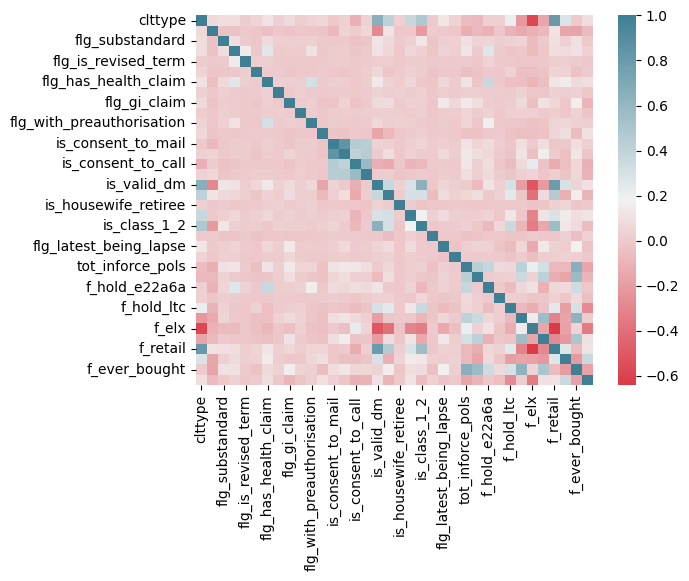

In [11]:
n_cols = list(x.select_dtypes(include=["int64", "float64"]).columns)

correlation = df[n_cols].corr()
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(correlation, cmap = cmap)

Comparing the distribution of client types according to f_purchase_lh status
- There is a higher proportion of type 2 customers among those who purchase a product in the next 3 months

<Axes: xlabel='clttype', ylabel='Proportion'>

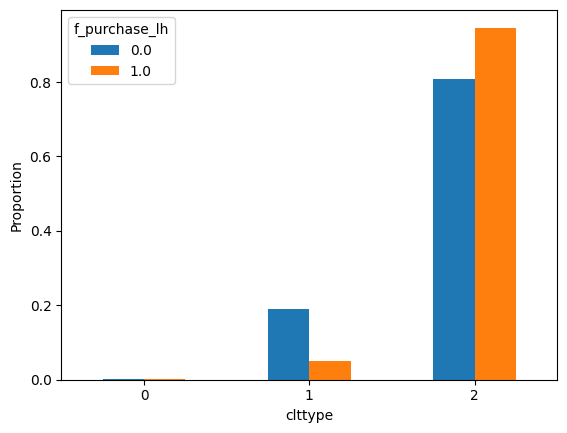

In [12]:
ct1 = pd.crosstab(df['clttype'], df['f_purchase_lh'],normalize = 'columns')
ct1.plot.bar(rot=1, ylabel = "Proportion")

Comparing consent to email across f_purchase_lh status
- Those who will buy a product are more likely to consent to mail

<Axes: xlabel='is_consent_to_mail', ylabel='Proportion'>

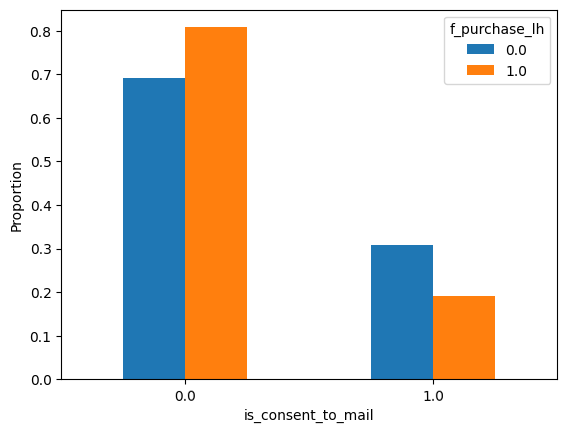

In [13]:
ct2 = pd.crosstab(df['is_consent_to_mail'], df['f_purchase_lh'],normalize = 'columns')
ct2.plot.bar(rot=1, ylabel = "Proportion")

Comparing validity of emails by f_purchase_lh status
- Customers who do not buy a product in the next 3 months are more likely to leave an invalid email

<Axes: xlabel='is_valid_email', ylabel='Proportion'>

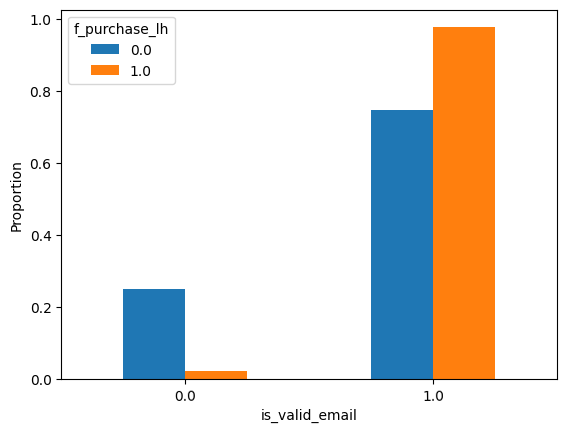

In [14]:
ct3 = pd.crosstab(df['is_valid_email'], df['f_purchase_lh'],normalize = 'columns')
ct3.plot.bar(rot=1, ylabel = "Proportion")

Comparing distribution of total insured sums according to f_purchase_lh status
- Those who purchase a product in the next 3 months tend to spend more

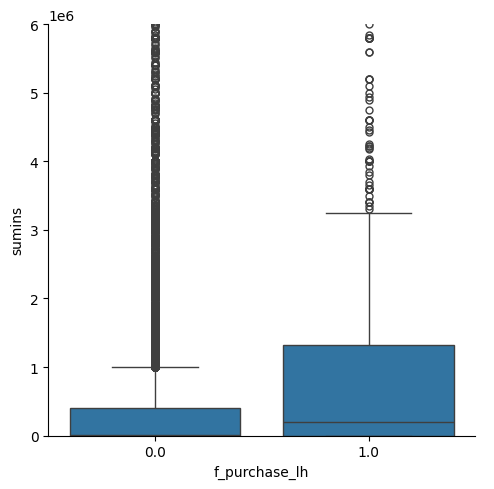

In [15]:
k = sns.catplot(y = "sumins", x = "f_purchase_lh", kind = "box", data = df)
k.set(ylim = (0,6000000))

Comparing distribution of products bought according to f_purchase_lh status
- Those who purchase a product in the next 3 months tend to have bought more products

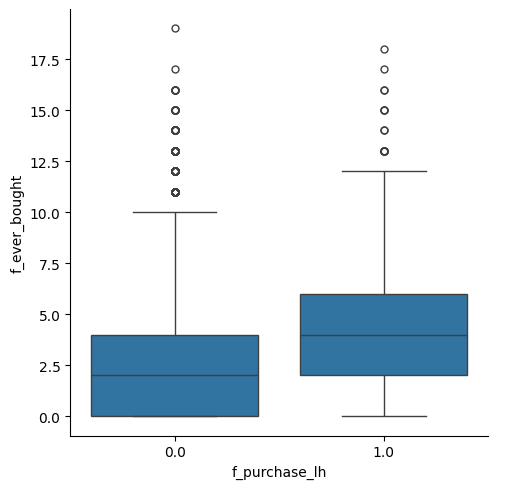

In [16]:
sns.catplot(y = "f_ever_bought", x = "f_purchase_lh", kind = "box", data = df)

### Model training

Applying SMOTE to balance dataset

In [17]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

print('Before:', Counter(y_train))
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print('After:', Counter(y_train))

Before: Counter({0.0: 13809, 1.0: 584})
After: Counter({1.0: 13809, 0.0: 13809})


Running KNN model with range of values for k (1-10)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

train_acc_k = []
val_acc_k = []

for i in range(1,11):
    knn_clf = KNeighborsClassifier(n_neighbors=i)
    knn_clf.fit(X_train, y_train)
    y_val_predk = knn_clf.predict(X_val)
    train_acc_k.append(knn_clf.score(X_train, y_train))
    val_acc_k.append(knn_clf.score(X_val, y_val))

print(train_acc_k)
print(val_acc_k)

[1.0, 0.9515533347816642, 0.9220435947570426, 0.9099862408574119, 0.8925338547324209, 0.8875009052067492, 0.8741038453182707, 0.8717865160402636, 0.861539575639076, 0.8603084944601347]
[0.8149485968324535, 0.8582939705473742, 0.783828841344818, 0.819949986107252, 0.7629897193664907, 0.7896637954987497, 0.7468741317032509, 0.7691025284801334, 0.7379827729924979, 0.7616004445679355]


k = 2 had the highest validation accuracy. Let's take a look at its confusion matrix and k-fold cross validation scores

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      3473
         1.0       0.06      0.19      0.09       126

    accuracy                           0.86      3599
   macro avg       0.51      0.54      0.50      3599
weighted avg       0.94      0.86      0.89      3599



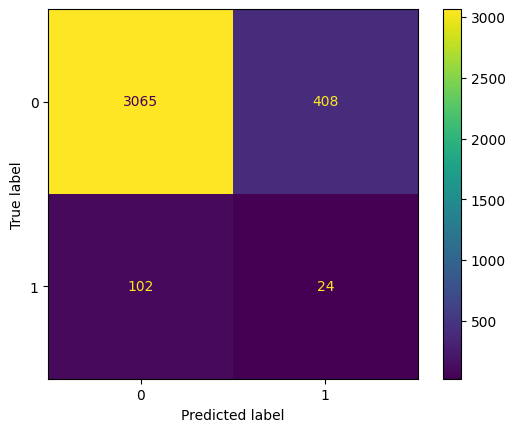

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

knn_clf2 = KNeighborsClassifier(n_neighbors=2)
knn_clf2.fit(X_train, y_train)
y_val_pred4 = knn_clf2.predict(X_val)

y_val_pred4 = knn_clf2.predict(X_val)
print(classification_report(y_val, y_val_pred4))


cm = confusion_matrix(y_val, y_val_pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) 
disp.plot()

In [34]:
from sklearn.model_selection import cross_val_score

model4 = knn_clf2
scores4 = cross_val_score(model4, x, y, cv=5)
print(scores4, scores4.mean())

[0.95915532 0.95887747 0.95719844 0.9594219  0.9585881 ] 0.9586482472047313


Fitting a SVM model
- It has lower training and validation accuracy but its k-fold cross validation scores are higher

In [21]:
from sklearn.svm import SVC

svm_clf = SVC(C=1)
svm_clf.fit(X_train, y_train)
print("train accuracy: ", svm_clf.score(X_train, y_train))
print("val accuracy: ", svm_clf.score(X_val, y_val))

train accuracy:  0.6100007241653994
val accuracy:  0.6896360100027785


              precision    recall  f1-score   support

         0.0       0.97      0.70      0.81      3473
         1.0       0.05      0.47      0.10       126

    accuracy                           0.69      3599
   macro avg       0.51      0.58      0.45      3599
weighted avg       0.94      0.69      0.79      3599



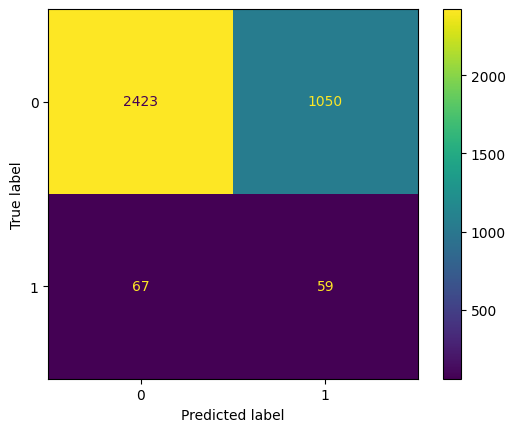

In [22]:
y_val_pred5 = svm_clf.predict(X_val)
print(classification_report(y_val, y_val_pred5))


cm = confusion_matrix(y_val, y_val_pred5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

In [33]:
model5 = svm_clf
scores5 = cross_val_score(model5, x, y, cv=5)
print(scores5, scores5.mean())

[0.9605446  0.9605446  0.96053363 0.96053363 0.96053363] 0.9605380161650116


Fitting a decision tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
print("train accuracy: ", dt_clf.score(X_train, y_train))
print("val accuracy: ", dt_clf.score(X_val, y_val))

train accuracy:  1.0
val accuracy:  0.9258127257571548


              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      3473
         1.0       0.15      0.23      0.18       126

    accuracy                           0.93      3599
   macro avg       0.56      0.59      0.57      3599
weighted avg       0.94      0.93      0.93      3599



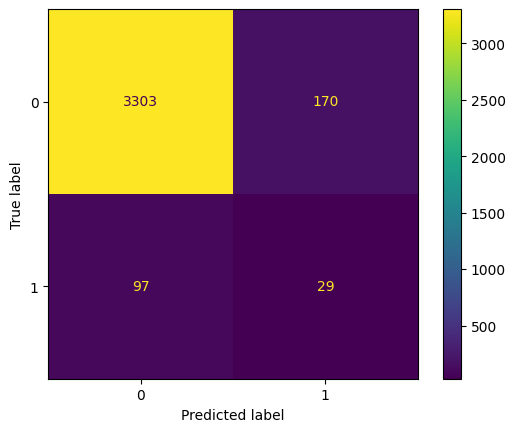

In [25]:
y_val_pred1 = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred1))

cm = confusion_matrix(y_val, y_val_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) 
disp.plot()

In [35]:
model1 = dt_clf
scores1 = cross_val_score(model1, x, y, cv=5)
print(scores1, scores1.mean())

[0.93776049 0.93192553 0.934408   0.9360756  0.93218455] 0.9344708345734356


Fitting a random forest with tuned parameters

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 15,
                            criterion = "entropy",
                            max_depth=None,
                            max_features= 5,
                            bootstrap=True,
                            n_jobs=1,
                            random_state=0)
rf1.fit(X_val, y_val); 

parameters = {'n_estimators':[5, 10, 15, 20],'max_features':[5,10,20]}

In [29]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(rf1, parameters)  
clf.fit(X_train, y_train)
clf.best_params_ 

{'max_features': 5, 'n_estimators': 20}

train accuracy:  0.5045622420160765
val accuracy:  0.9972214504028897
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3473
         1.0       1.00      0.92      0.96       126

    accuracy                           1.00      3599
   macro avg       1.00      0.96      0.98      3599
weighted avg       1.00      1.00      1.00      3599



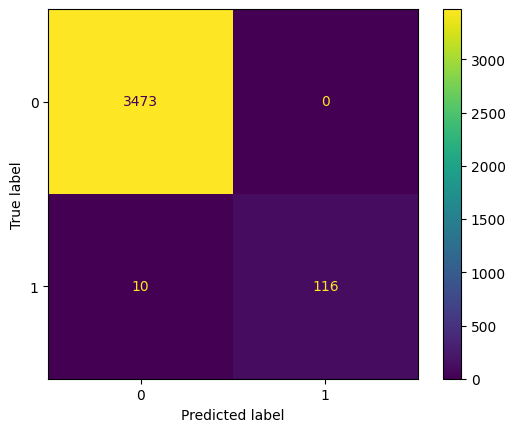

In [30]:
rf2 = RandomForestClassifier(n_estimators = 20,
                            criterion = "entropy",
                            max_depth=None,
                            max_features= 5,
                            bootstrap=True,
                            n_jobs=1,
                            random_state=0)
rf2.fit(X_val, y_val); 
print("train accuracy: ", rf2.score(X_train, y_train))
print("val accuracy: ", rf2.score(X_val, y_val))

y_val_pred3 = rf2.predict(X_val)
print(classification_report(y_val, y_val_pred3))


cm = confusion_matrix(y_val, y_val_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) 
disp.plot()

In [32]:
model3 = rf2
scores3 = cross_val_score(model3, x, y, cv=5)
print(scores3, scores3.mean())

[0.9605446  0.96276744 0.96081156 0.96108949 0.96081156] 0.9612049298481867


The random forest has the highest validation accuracy and k-fold cross validation scores. This shall be the final mdoel.

In [36]:
def train_model():
    model = RandomForestClassifier(n_estimators = 20,
                            criterion = "entropy",
                            max_depth=None,
                            max_features= 5,
                            bootstrap=True,
                            n_jobs=1,
                            random_state=0)
    model.fit(X_val, y_val)
    return model



## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [37]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    for col in hidden_data.columns.values:
        if hidden_data[col].isna().sum()/hidden_data.shape[0] > 0.5 and col != 'f_purchase_lh':
            hidden_data = hidden_data.drop(col, axis = 1)

    single_val = []

    for col in hidden_data.columns.values:
        if len(hidden_data[col].value_counts()) == 1:
            single_val.append(col)
        
    hidden_data = hidden_data.drop(single_val, axis = 1)

    hidden_data['flg_is_revised_term'].fillna(0)

    numeric_cols = list(hidden_data.select_dtypes(include=["int64", "float64"]).columns)
    binary_cols = []

    for col in numeric_cols:
        if col != 'f_purchase_lh' and len(hidden_data[col].value_counts()) == 2:
            binary_cols.append(col)
            numeric_cols.remove(col)
        
    hidden_data[binary_cols] = hidden_data[binary_cols].apply(lambda x: x.fillna(x.mode()))  
    hidden_data[numeric_cols] = hidden_data[numeric_cols].apply(lambda x: x.fillna(x.median()))

    from datetime import date
    from datetime import datetime
    today = date.today()

    dob = hidden_data["cltdob_fix"]
    hidden_data['cltdob_fix'] = pd.to_datetime(hidden_data['cltdob_fix'], format="%Y-%m-%d", errors='coerce')
    hidden_data['age'] = today.year - hidden_data['cltdob_fix'].dt.year 
    hidden_data = hidden_data.drop('cltdob_fix', axis = 1)

    hidden_data = hidden_data.drop('min_occ_date', axis = 1)

    ape = [col for col in hidden_data if col.startswith('ape')]
    prempaid = [col for col in hidden_data if col.startswith('prempaid')]
    sumins = [col for col in hidden_data if col.startswith('sumins')]
    feverbought = [col for col in hidden_data if col.startswith('f_ever_bought')]
    hidden_data['ape'] = hidden_data[ape].sum(axis = 1)
    hidden_data['prempaid'] = hidden_data[prempaid].sum(axis = 1)
    hidden_data['sumins'] = hidden_data[sumins].sum(axis = 1)
    hidden_data['f_ever_bought'] = hidden_data[feverbought].sum(axis = 1)
    hidden_data = hidden_data.drop(ape, axis = 1)
    hidden_data = hidden_data.drop(prempaid, axis = 1)
    hidden_data = hidden_data.drop(sumins, axis = 1)
    hidden_data = hidden_data.drop(feverbought, axis = 1)

    float_cols = list(hidden_data.select_dtypes(include=["float64"]).columns)
    hidden_data[float_cols] = hidden_data[float_cols].apply(lambda x: x.fillna(0)) 

    obj_cols = ['hh_20', 'pop_20']
    hidden_data[obj_cols] = hidden_data[obj_cols].apply(lambda x: x.fillna(round(x.median())))  

    hidden_data = hidden_data.drop(['race_desc', 'ctrycode_desc', 'hh_size_est', 'annual_income_est', 'cltsex_fix'], axis = 1)

    nmonths = [col for col in hidden_data if col.startswith('n_months')]

    hidden_data[nmonths] = hidden_data[nmonths].astype(str).astype(int)
    hidden_data['nmonths'] = hidden_data[nmonths].min(axis = 1)
    hidden_data = hidden_data.drop(nmonths, axis = 1)

    from sklearn.preprocessing import LabelEncoder

    enc = LabelEncoder()
    enc.fit(hidden_data["clttype"]) 
    enc.fit(hidden_data["stat_flag"])

    hidden_data["clttype"] = enc.fit_transform(hidden_data["clttype"])
    hidden_data["stat_flag"] = enc.fit_transform(hidden_data["stat_flag"])

    hidden_data = hidden_data.drop(["clntnum"], axis = 1)
    
    #return hidden_data.columns
    tm = train_model()

    result = tm.predict(hidden_data.to_numpy()).tolist()
    return result

##### Cell to check testing_hidden_data function

In [38]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!